LOADING DATASET

In [3]:
import pandas as pd 
df = pd.read_csv('Mall_Customers_Enhanced.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Group,Estimated Savings (k$),Credit Score,Loyalty Years,Preferred Category
0,1,Male,19,15,39,18-25,11.10,456,3,Budget
1,2,Male,21,15,81,18-25,6.90,300,6,Luxury
2,3,Female,20,16,6,18-25,15.36,594,2,Budget
3,4,Female,23,16,77,18-25,7.79,300,6,Luxury
4,5,Female,31,17,40,26-35,12.47,480,5,Budget


DATA PROFILING & IMPUTATION

In [5]:
#Data profiling checks to investigate the data 
print(df.isna().sum())
print(df.nunique())
print(df.duplicated().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
Age Group                 4
Estimated Savings (k$)    0
Credit Score              0
Loyalty Years             0
Preferred Category        0
dtype: int64
CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
Age Group                   5
Estimated Savings (k$)    191
Credit Score               91
Loyalty Years               8
Preferred Category          4
dtype: int64
0


In [6]:
#Fill in missing values 
missing = df[df['Age Group'].isna()]
missing 
df['Age Group'].fillna('18-25',inplace=True)
print(df.isna().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
Age Group                 0
Estimated Savings (k$)    0
Credit Score              0
Loyalty Years             0
Preferred Category        0
dtype: int64


C:\Users\T480\AppData\Local\Temp\ipykernel_21436\1550413563.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age Group'].fillna('18-25',inplace=True)


EXPLORATORY DATA ANALYSIS BY DATA TYPE 

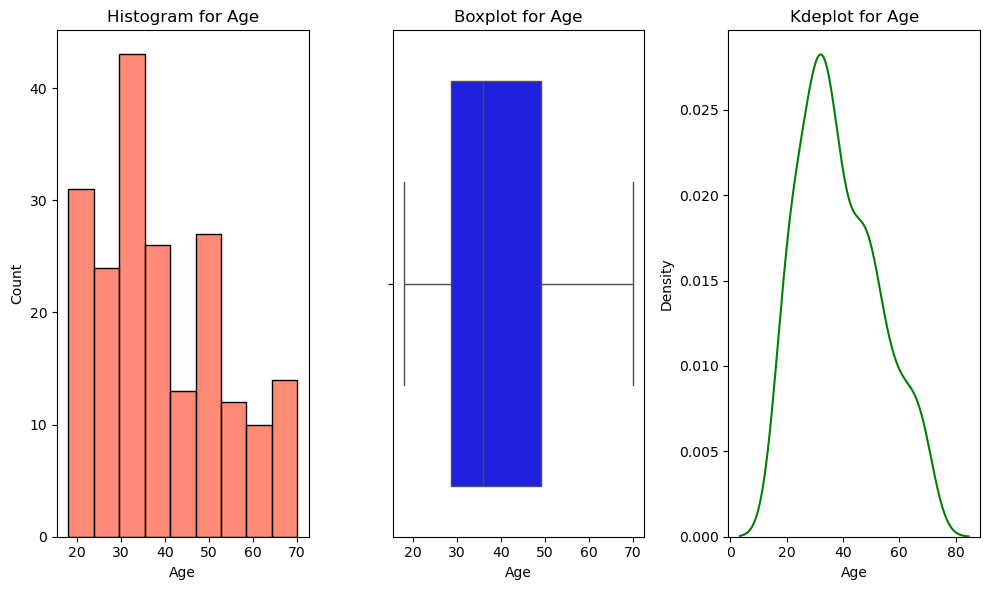

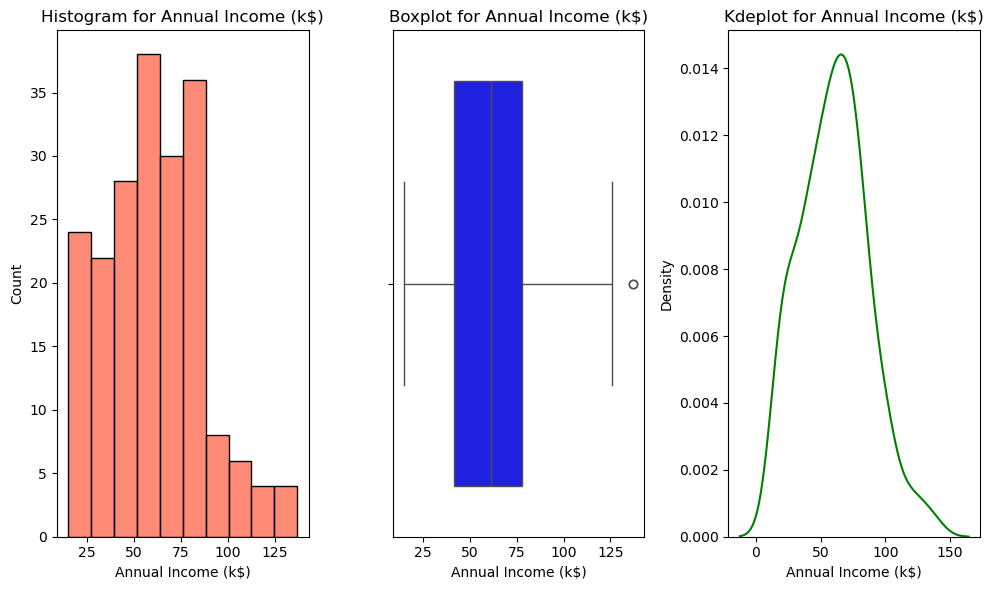

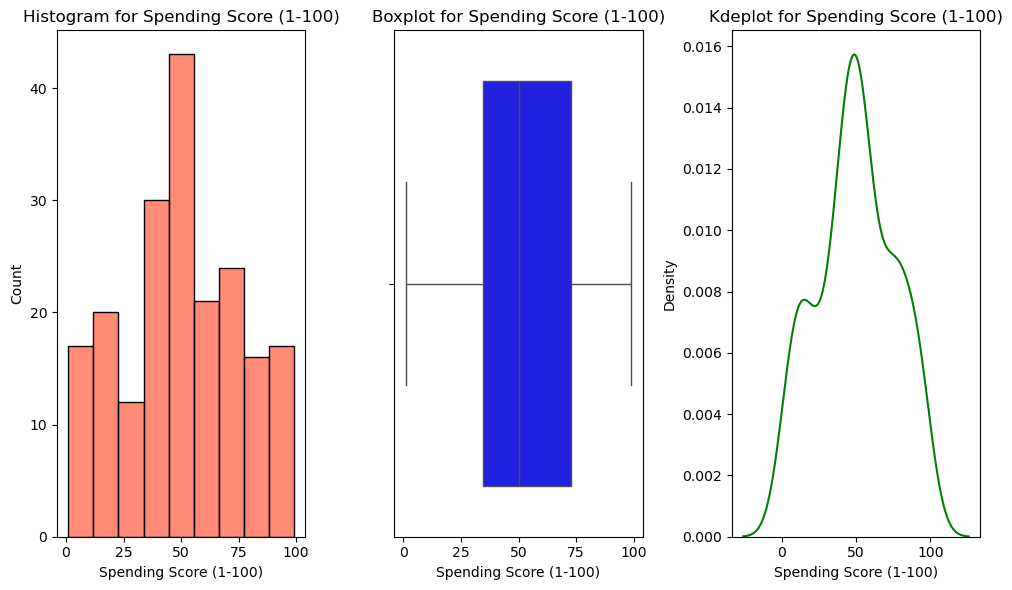

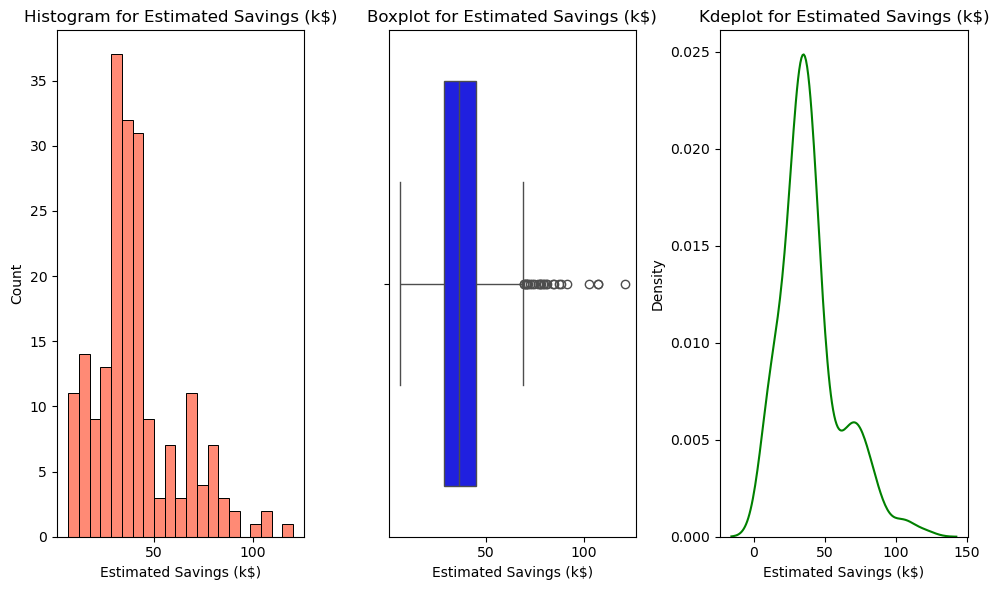

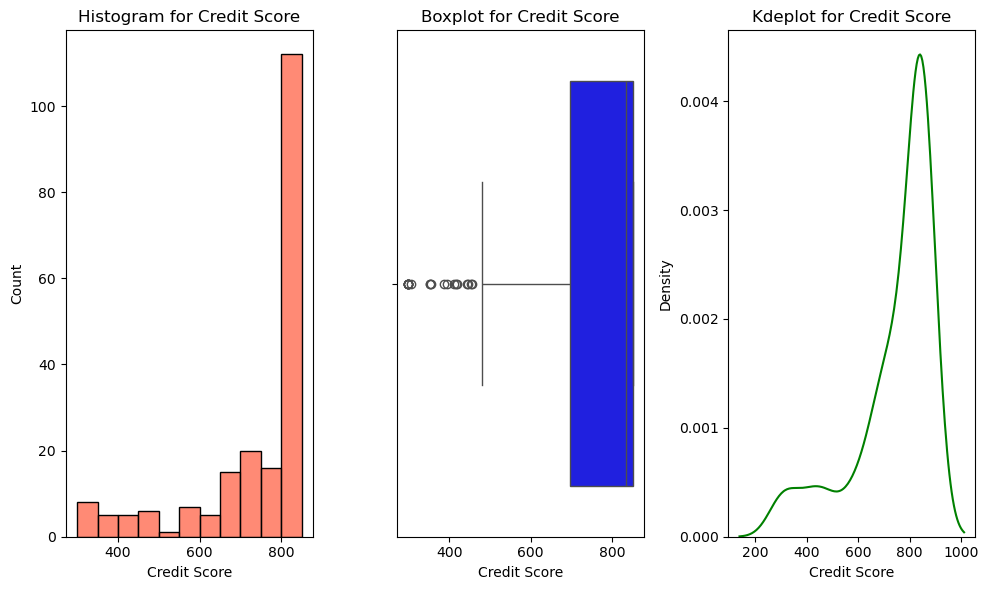

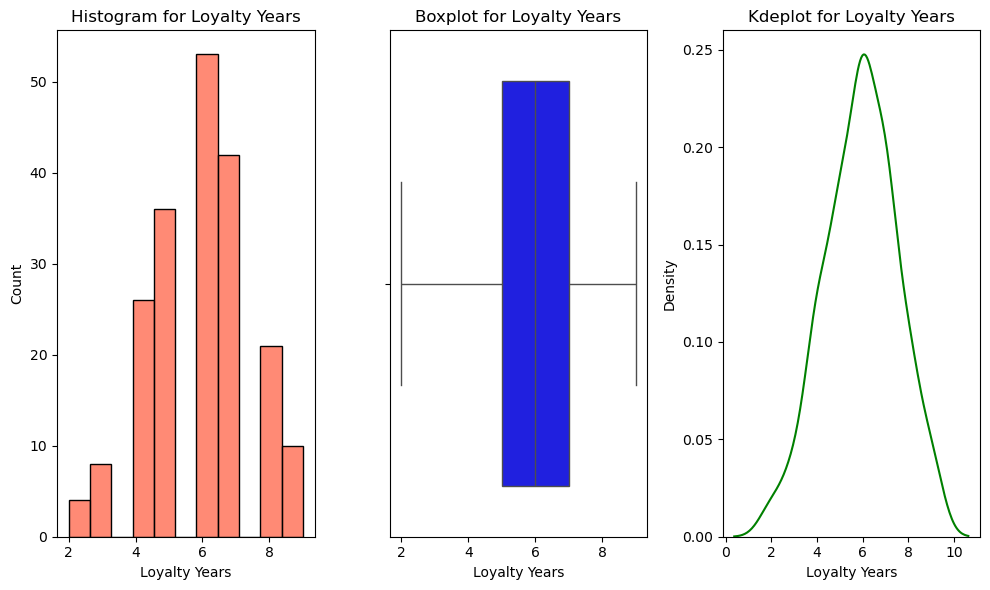

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

#EDA for numerical columns 
df_num = df.select_dtypes(include='number')
df_num.drop(columns='CustomerID',inplace=True)

for col in df_num.columns:
    plt.figure(figsize=(10,6))
    plt.subplot(1,3,1)
    sns.histplot(data=df,x=df[col],color='tomato')
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    
    plt.subplot(1,3,2)
    sns.boxplot(data=df,x=df[col],color='blue')
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    
    plt.subplot(1,3,3)
    sns.kdeplot(data=df,x=df[col],color='green')
    plt.title(f'Kdeplot for {col}')
    plt.xlabel(col)
    
    plt.tight_layout() 
    plt.show()

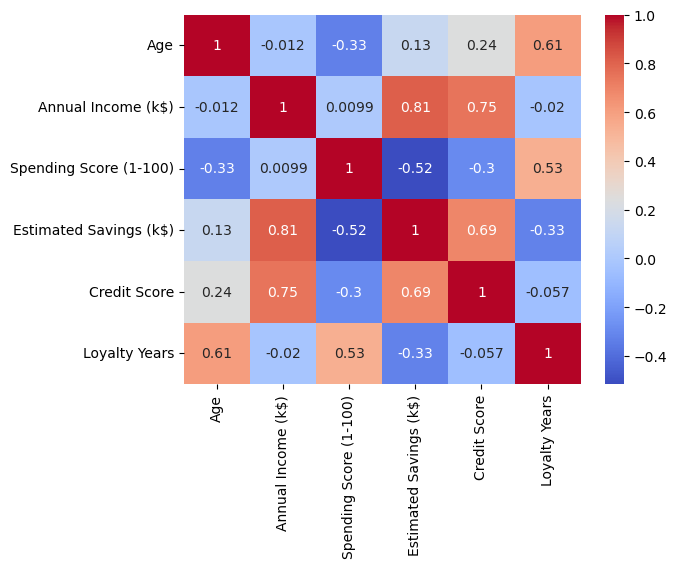

In [9]:
#Correlation matrix for numerical columns to see relationships 
corr = df_num.corr()
sns.heatmap(corr,cmap='coolwarm',annot=True)
plt.show()

CLEANED DATASET CREATION

In [11]:
#Detection of outliers and creating a new dataframe that with no outliers. KMeans is sensitive to outliers
outliers = ['Annual Income (k$)','Estimated Savings (k$)','Credit Score']
for x in outliers: 
    lower = df[x].quantile(0.25)
    upper = df[x].quantile(0.75)
    IQR = upper - lower
    df_clean = df[~((df[x] < (lower - 1.5*IQR)) | (df[x] > (upper + 1.5*IQR)))]
    df_clean.drop(columns=['CustomerID','Age Group'],inplace=True)


C:\Users\T480\AppData\Local\Temp\ipykernel_21436\1797832234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['CustomerID','Age Group'],inplace=True)
C:\Users\T480\AppData\Local\Temp\ipykernel_21436\1797832234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['CustomerID','Age Group'],inplace=True)
C:\Users\T480\AppData\Local\Temp\ipykernel_21436\1797832234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

KMeans MODEL BUILD AND IMPLEMENTATION

In [13]:
#Libraries to scale numerical columns and encode categorical columns. A pipeline to perform actions in steps and KMeans function 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

cat_cols = ['Gender', 'Preferred Category']
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)','Estimated Savings (k$)','Credit Score','Loyalty Years']

In [14]:
#Preprocesser for our dataset(Scale and Encode), Function to take the dataset as an argument to visualize line plot for Elbow method
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])  

def cluster_numbers(x):
    inertia = {}
    K = range(2,10)
    X_scaled = preprocessor.fit_transform(x)
    for k in K:
        k_means = KMeans(n_clusters=k, random_state=42)
        k_means.fit(X_scaled)
        inertia[k] = k_means.inertia_
    
    plt.plot(list(inertia.keys()), list(inertia.values()), color='red',marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

C:\Users\T480\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\T480\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\T480\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\T480\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

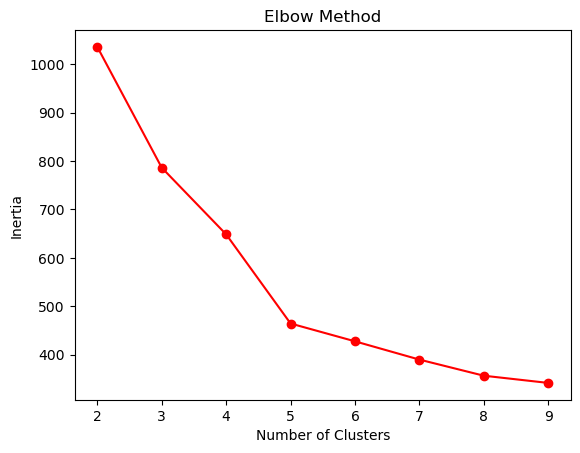

In [15]:
cluster_numbers(df_clean)

In [16]:
#Kmeans model - with the identified number of clusters to get results 
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clusterer', kmeans)])

X = df_clean[num_cols + cat_cols]
pipeline.fit(X) 

C:\Users\T480\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,steps,"[('preprocessor', ...), ('clusterer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
#Adding 'Cluster' column to the dataset(New Category)
df_clean['Cluster'] = pipeline.named_steps['clusterer'].labels_
print(df_clean['Cluster'].unique())
print(f"Number of unique clusters: {len(df_clean['Cluster'].unique())}")

[2 0 1 3]
Number of unique clusters: 4


C:\Users\T480\AppData\Local\Temp\ipykernel_21436\3956110499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster'] = pipeline.named_steps['clusterer'].labels_


In [18]:
#Threshold for highspenders - New binary column
import numpy as np

df_clean['High Spenders'] = np.where(df_clean['Spending Score (1-100)'] > 50, 1, 0)

C:\Users\T480\AppData\Local\Temp\ipykernel_21436\2508525594.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['High Spenders'] = np.where(df_clean['Spending Score (1-100)'] > 50, 1, 0)


RESULTS AND INTERPRETATION

In [20]:
#Dataframe with our summary stats based on Cluster 
customer_profile = df_clean.groupby('Cluster').mean(numeric_only=True)
customer_profile 

,Age,Annual Income (k$),Spending Score (1-100),Estimated Savings (k$),Credit Score,Loyalty Years,High Spenders
Cluster,,,,,,,
0,24.272727,65.818182,39.787879,49.664848,820.909091,3.939394,0.363636
1,49.472727,74.763636,33.836364,59.147091,844.763636,6.163636,0.145455
2,46.641509,37.396226,39.452830,26.567925,669.490566,6.169811,0.358491
3,32.692308,86.538462,82.128205,39.195641,830.820513,6.871795,1.000000


C:\Users\T480\AppData\Local\Temp\ipykernel_21436\920939860.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean,x='Cluster',palette='tab10')


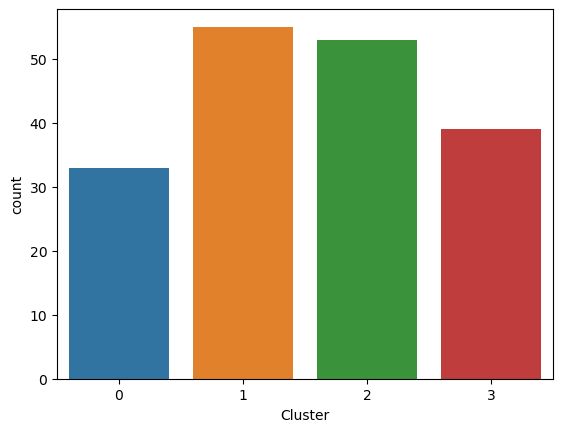

In [21]:
#Plot to show cluster distribution in the dataset 
sns.countplot(data=df_clean,x='Cluster',palette='tab10')
plt.show()

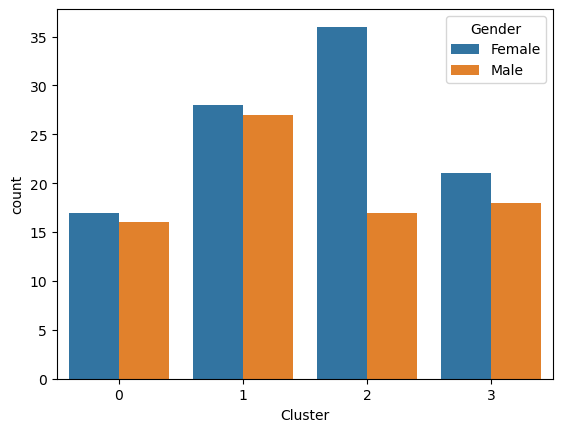

In [22]:
#Plot to show which gender is the most dominant in each cluster
count_data = df_clean.groupby(['Cluster', 'Gender']).size().reset_index(name='count')
sns.barplot(data=count_data,x='Cluster',y='count', hue='Gender')
plt.show()

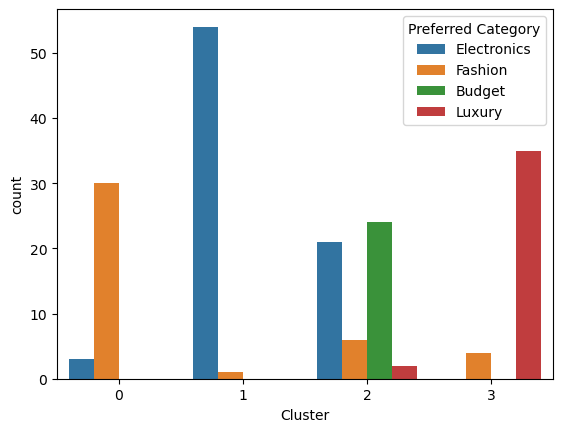

In [23]:
#Plot to show which category each cluster Prefers
count_data = df_clean.groupby(['Cluster', 'Preferred Category']).size().reset_index(name='count')
sns.barplot(data=count_data,x='Cluster',y='count', hue='Preferred Category')
plt.show()